<a href="https://colab.research.google.com/github/mancatha/P5/blob/main/P5model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers
!pip install transformers[torch] --upgrade
!pip install accelerate -U
!pip install -U huggingface_hub

  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
  Using cached huggingface_hub-0.19.0-py3-none-any.whl (311 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.19.0 which is incompatible.


In [2]:
import os
import pandas as pd
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')
from huggingface_hub import notebook_login

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [4]:
#downloding the train file from github using the url
!wget -O Train.csv "https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/blob/master/zindi_challenge/data/Train.csv"

--2023-11-12 02:24:25--  https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/blob/master/zindi_challenge/data/Train.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5340 (5.2K) [text/plain]
Saving to: ‘Train.csv’

Train.csv           100%[===================>]   5.21K  --.-KB/s    in 0s      

2023-11-12 02:24:25 (65.5 MB/s) - ‘Train.csv’ saved [5340/5340]



In [5]:
# Load the dataset and display some values
#df = pd.read_csv('../data/Train.csv')
df = pd.read_csv("https://github.com/Azubi-Africa/Career_Accelerator_P5-NLP/raw/master/zindi_challenge/data/Train.csv")



# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [6]:
# Assuming you have a DataFrame named df
unique_safe_text = df['safe_text'].unique()

# Print the unique values
for text in unique_safe_text:
    print(text)

Streaming output truncated to the last 5000 lines.
#Vaccinate.
Agora NightLife #BurgLife #BacardiPromotions #MMR #teamfreepour #humblebeginnings @ Agora Nightlife <url>
Scared of the flu vaccine? Let's see what's really inside it. <url>
We always make sure our people are taken care of 😌 , only 2/3 of the MMR team🎩👔💼  #IRIE #Blessed #MMR… <url>
<user> In Ethiopia 32 <user> members were able to immunize 1,000 children against polio <url> <url>
#Vaccinate or Not? Did you regret having your kids vaccinated? Just seeing where everyone is at on this!
VACCINATE YOUR GODDAMN CHILDREN.
<user> I would appreciate if you stop the assault on vaccines not causing autism if you are not fully informed. Thank you.
If my kid can't take a PB&amp;J swich to school, you can't send your unvaccinated, disease spreading kid to school either #VaccineWar
<user> I had measles, mumps, chicken pox but I didn't get whooping cough which was the scary one.
vaccinate your rugrats please RT “<user> Measles outbreaks sp

In [7]:
# Define a function to clean text and remove specific emojis
def clean_text(text):
    # Remove URLs and user mentions
    text = ' '.join(word for word in text.split() if not word.startswith('http'))
    text = ' '.join(word for word in text.split() if not word.startswith('@'))

    # Remove <url>
    text = text.replace(' < url >','')
    text = text.replace('< url >','')
    # Remove <user>
    text = text.replace('< user >', '')
    # Convert text to lowercase
    text = text.lower()
    # Remove multiple consecutive special characters with a single occurrence
    text = re.sub(r'([?*#!.-:;])\1+', r'\1', text)
    # Remove extra spaces
    text = ' '.join(text.split())

    # Define a list of emojis to be removed
    emojis_to_remove = ['😊', '🙏', '💉', '👶', '😬', '👍', '😭', '😂', '💁', '😁', '😪', '😷', '🙋', '😵', '😌', '😴',
                        '😠', '🍴', '😳', '😒', '😩', '😌', '🎩', '👔', '💼', '😖', '😡', '❤', '👍', '😓', '😷', '😡',
                        '😎', '😂', '👌', '😂', '😩', '🙈', '💉', '💉', '💉', '😭', '☺️', '😷', '✌️', '👍', '😡', '💁',
                        '😂', '😭', '😒', '😳', '😳', '😷', '😳', '⭐️', '🍸', '🍻', '👆', '👉', '😭', '💌', '😷', '❤️',
                        '😂', '😂', '😂', '🔥', '🔥', '🔥', '😩', '💉', '💊', '🏃', '😭', '😏', '🏰', '🍕', '🍕', '🍕',
                        '😥', '🔥', '🔥', '🔥', '🔥', '🔥', '🙌', '😂', '😒', '😳', '❗️', '❗️', '❗️', '🏥', '🍓', '🙏',
                        '🐶','✅','😐','😃','🌍','😜','😫','❄️💜','😐','😲','😐','😑','😑',' 😃','😐','🌊','🌕','🔮','😢',
                        ' ','😢','😤','💥','💩','👎','♥','🆒','🌞','🔸','😢','🌍','💙','🎶','😆','😑',' 🚫','😞','😶','😟',
                        '✌','🎊','😄','😣','😘','👏','😰','😍','💯','💖','💕','👓','👴','👵','🎉','😱','😘','😍','😚','😘',
                        '😘','😍','👏','😮','😕','💕','🙅','🙆','🎧','🎼','🎵','🏢','💀','👂','😕','✋','🏄','💵️','☕️','🐸',
                        '🐷','🐷','🐷/🐺/🐍😝','😻','😝','🌀','🐹',' 🔊🔊🔊','🐹','😅','😅','😅','✔️','☯','','💪','👀','💮','😋',]

    # Remove specific emojis from the text
    for emoji in emojis_to_remove:
        text = text.replace(emoji, '')

    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Join tokens back into cleaned text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the cleaning function to the 'safe_text' column
df['safe_text'] = df['safe_text'].apply(clean_text)

# Print the cleaned DataFrame
print(df)


       tweet_id                                          safe_text  label  \
0      CL1KWCMY  & amp ; big homie meanboy30 # meanboy # mb # m...    0.0   
1      E3303EME  'm 10 % thinking devoting career proving autis...    1.0   
2      M4IVFSMS      # whatcausesautism vaccines , vaccinate child   -1.0   
3      1DR6ROZ4  mean immunize kid something wo n't secretly ki...   -1.0   
4      J77ENIIE  thanks < user > catch performing la nuit nyc 1...    0.0   
...         ...                                                ...    ...   
9996   IU0TIJDI  living time sperm used waste jenny mccarthy be...    1.0   
9997   WKKPCJY6  < user > < user > spite measles outbreaks , ju...    1.0   
9998   ST3A265H  interesting trends child immunization oklahoma...    0.0   
9999   6Z27IJGD  cdc says measles highest levels decades : ( < ...    0.0   
10000  P6190L3Q  pneumonia vaccine : women w risk pulmonary dis...    1.0   

       agreement  
0       1.000000  
1       1.000000  
2       1.000000  

In [8]:
from imblearn.over_sampling import RandomOverSampler

In [9]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   9999 non-null   object 
 1   safe_text  9999 non-null   object 
 2   label      9999 non-null   float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [11]:

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)
# Assuming `train` is your original DataFrame

# Separate features and target variable
X = df.drop(['label', 'tweet_id', 'safe_text'], axis=1)
y = df['label']

# Convert label column to numeric type if needed
# You can skip this step if the label column is already numeric
y = y.astype(float)

# Apply RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

In [12]:
class_counts = df['label'].value_counts()
print(class_counts)

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64


In [13]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,mickey 's measles gone international < url >,0.0,1.000000
3907,5GV8NEZS,s1256 [ new ] extends exemption charitable imm...,0.0,1.000000
795,EI10PS46,< user > ignorance vaccines n't dangerous inno...,1.0,0.666667
5793,OM26E6DG,pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,news 've gone like 10 mmr,0.0,1.000000


In [14]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,children 's museum houston offer free vaccinat...,1.0,1.000000
1754,2DD250VN,< user > . properly immunized prior performanc...,1.0,1.000000
3325,ESEVBTFN,< user > thx posting vaccinations imperative ....,1.0,1.000000
1485,S17ZU0LC,baby exactly everyone needs vaccinate < url > ...,1.0,0.666667
4175,IIN5D33V,"meeting tonight , 8:30pm room 32 student cente...",1.0,1.000000


In [15]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [16]:
#after saving our dataset we load the dataset
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [17]:


tokenizer = AutoTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

In [21]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding = True, truncation = True,max_length = 128)

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [23]:

# Load your model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("mdhugol/indonesia-bert-sentiment-classification",num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("mdhugol/indonesia-bert-sentiment-classification")

In [32]:
max_length = tokenizer.model_max_length
print("Max Length:", max_length)


Max Length: 1000000000000000019884624838656


In [24]:
# Split the dataset into training and evaluation sets
train_dataset = dataset['train']
eval_dataset = dataset['eval']

In [25]:
training_args = TrainingArguments(
    output_dir="sentiment_analysis_trainer_model",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate = 1e-4,
    load_best_model_at_end=True,
    push_to_hub = True,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,

)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [26]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall}

In [27]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding ='max_length',return_tensors='pt')

In [29]:
notebook_login()

In [37]:
# Initialize the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),  # Specify your data collator if needed
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Specify your metrics function

)

In [38]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.812500,0.777205,0.700500,0.648224,0.700500
2,0.964900,0.951270,0.491000,0.241081,0.491000
3,0.970300,0.959011,0.491000,0.241081,0.491000
4,0.956700,0.961211,0.405500,0.164430,0.405500
5,0.965000,0.950483,0.491000,0.241081,0.491000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

TrainOutput(global_step=5000, training_loss=0.9270831359863281, metrics={'train_runtime': 699.1212, 'train_samples_per_second': 57.208, 'train_steps_per_second': 7.152, 'total_flos': 1179132503680152.0, 'train_loss': 0.9270831359863281, 'epoch': 5.0})

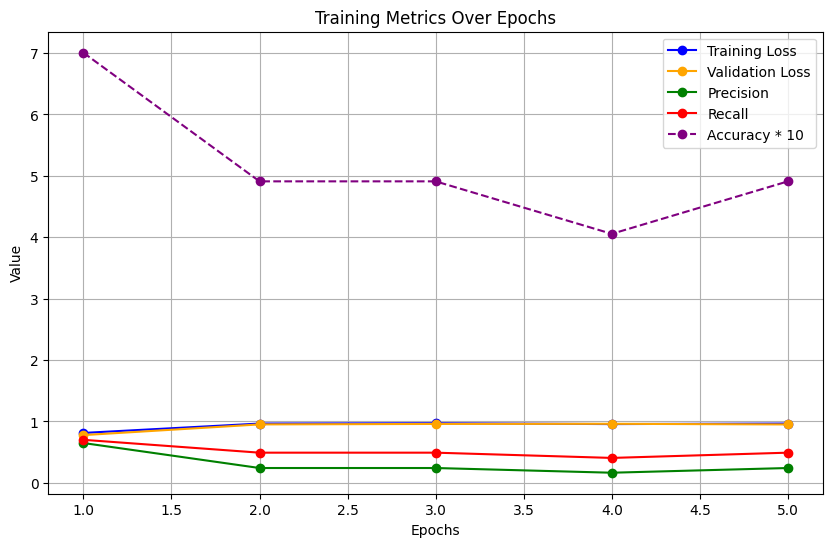

In [42]:

import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]
training_loss = [0.812500, 0.964900, 0.970300, 0.956700, 0.965000]
validation_loss = [0.777205, 0.951270, 0.959011, 0.961211, 0.950483]
accuracy = [0.700500, 0.491000, 0.491000, 0.405500, 0.491000]
precision = [0.648224, 0.241081, 0.241081, 0.164430, 0.241081]
recall = [0.700500, 0.491000, 0.491000, 0.405500, 0.491000]

# Scale the accuracy values for better visibility on the graph
scaled_accuracy = np.array(accuracy) * 10

# Create subplots
plt.figure(figsize=(10, 6))

# Plot the losses, precision, recall, and scaled accuracy
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='orange')
plt.plot(epochs, precision, label='Precision', marker='o', color='green')
plt.plot(epochs, recall, label='Recall', marker='o', color='red')
plt.plot(epochs, scaled_accuracy, label='Accuracy * 10', marker='o', linestyle='dashed', color='purple')

# Customize the plot
plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()



In [43]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),  # DataCollatorWithPadding is correctly imported
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [44]:
# Launch the final evaluation
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.7772045731544495,
 'eval_accuracy': 0.7005,
 'eval_precision': 0.6482244246223926,
 'eval_recall': 0.7005,
 'eval_runtime': 6.8809,
 'eval_samples_per_second': 290.659,
 'eval_steps_per_second': 36.332}

In [45]:
trainer.push_to_hub()

events.out.tfevents.1699756606.d938df6e4f3f.31341.3:   0%|          | 0.00/8.81k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1699758160.d938df6e4f3f.31341.4:   0%|          | 0.00/443 [00:00<?, ?B/s]

'https://huggingface.co/benmanks/sentiment_analysis_trainer_model/tree/main/'

In [46]:
tokenizer.push_to_hub( "sentiment_analysis")

CommitInfo(commit_url='https://huggingface.co/benmanks/sentiment_analysis/commit/3cf2ac0ebd8a3df8bfa064928e15e667c8339a64', commit_message='Upload tokenizer', commit_description='', oid='3cf2ac0ebd8a3df8bfa064928e15e667c8339a64', pr_url=None, pr_revision=None, pr_num=None)

In [47]:
from transformers import AutoConfig
model_path = f"sentiment_analysis_trainer_model"
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [48]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [52]:
from scipy.special import softmax
# Input preprocessing
text = "the vaccine is harmful!"
text = preprocess(text)

# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [53]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [54]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) POSITIVE 0.6245
2) NEUTRAL 0.2708
3) NEGATIVE 0.1046
